<a href="https://colab.research.google.com/github/CarmemMarinho/poscienciasdedados/blob/main/MVP_Sprint2_ParteA_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Machine Learning e Deep Learning

Profs. Tatiana Escovedo e Hugo Villamizar



Aluna: Carmem Maria Marinho de Souza Vasconcelos


## Parte A - Machine Learning - Problema de Regressão

### 1. Definição do Problema

O dataset utilizado neste projeto foi o Shop Customer Data, obtido no Kaggle (www.kaggle.com), que apresenta informações do perfil de clientes e a pontuação de gastos em uma loja. É um banco de dados gerado manualmente e foi coletado por meio de uma pesquisa realizada durante 1 ano sobre clientes.

O objetivo deste dataset é atribuir aos clientes uma pontuação de gastos, que pode representar o potencial de compra, possibilitando o proprietário de uma empresa entender melhor as características dos seus cliente e auxiliá-lo na elaboração de estratégias de aumento das vendas com base na personalização do atendimento.  

Inicialmente, vamos trabalhar na análise dos dados do dataset, em seguida faremos a visualização dos dados gerando alguns insights. Depois, passaremos para a etapa de tratamento e limpeza dos dados e, finalmente, a separação em grupos de teste e treino. Trata-se de um problema de aprendizado supervisionado.

Para mais detalhes sobre este dataset, consulte: https://www.kaggle.com/datasets/datascientistanna/customers-dataset

**Informações sobre os atibutos:**

1. **CustomerID** - Identificação do cliente

2. **Gender** - Gênero

3. **Age** - Idade

4. **Annual Income ($)** - Renda anual, em Dólar

5. **Spending Score** - Pontuação atribuída pela loja, com base no comportamento do cliente e na natureza do gasto

6. **Profession** - Profissão do cliente

7. **Work Experience** - Experiência de trabalho, em anos

8. **Family Size** - Quantidade de membros da família do cliente

Analisaremos quais são as características mais relevantes dos clientes para definição do seu potencial de compra e, dessa forma, criar possibilidades de segmentação dos clientes para campanhas de marketing.

A hipótese deste trabalho é como é possível atribuir uma pontuação para o potencial de compra de um cliente. Portanto, o objetivo deste trabalho é criar um modelo para a predição do score de um cliente a partir das dos dados de cadastro do mesmo.

Este é um problema de aprendizado supervisionado por regressão e a variável target será o "Score".

### 2. Carga de Dados

Primeiro, vamos fazer a importação das bibliotecas utilizadas neste projeto.

In [83]:
# Importação de Pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as ms
from os import statvfs_result
from matplotlib import cm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline


In [84]:
# Configuração para não exibir warnings
import warnings
warnings.filterwarnings("ignore")

Iremos usar o pacote Pandas (Python Data Analysis Library) para carregar um arquivo .csv disponível online e visualizar as 5 primeiras linhas do dataset importado.

In [85]:
# Importando dados de uma url para um dataframe

# Informa a url de importação do dataset
url = 'https://raw.githubusercontent.com/CarmemMarinho/poscienciasdedados/main/Customers.csv'

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

In [86]:
# Mostra as 5 primeras linhas do dataset
dataset.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


Para melhorar a visualização e leitura do dataset, vamos renomear as colunas do dataset, simplificando o texto.

In [87]:
# Informa os novos nomes que terão as colunas
colunas = ['ID', 'Gender', 'Age', 'Income', 'Score', 'Profession', 'Experience', 'Family']

# Lê o arquivo utilizando as colunas informadas
dataset = pd.read_csv(url, names=colunas, skiprows=1, delimiter=',')

# Mostra as 5 primeras linhas do dataset com as colunas renomeadas
dataset.head()

,ID,Gender,Age,Income,Score,Profession,Experience,Family
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


## 3. Pré-Processamento de Dados
A seguir, vamos realizar algumas operações de preparação de dados, como por exemplo, tratamento de valores missings (faltantes), limpeza de dados, tratamento das variáveis categóricas (One-Hot Encoding). Aplicaremos o holdout para efetuar a divisão em bases de treino (80%) e teste (20%) e separaremos em dez folds usando a validação cruzada.

### 3.1 Tratamento de Missings e Limpeza
Nesta fase de limpeza iremos analisar a possível ocorrência de nulls e/ou linhas duplicadas, e fazer os devidos ajustes, se necessário. Pecebemos que no dataset há missings aparentes, mas também há valores "0" que podem significar falta de dados de entrada.

In [88]:
# verificando nulls no dataset
dataset.isnull().sum()

ID             0
Gender         0
Age            0
Income         0
Score          0
Profession    35
Experience     0
Family         0
dtype: int64

<Axes: >

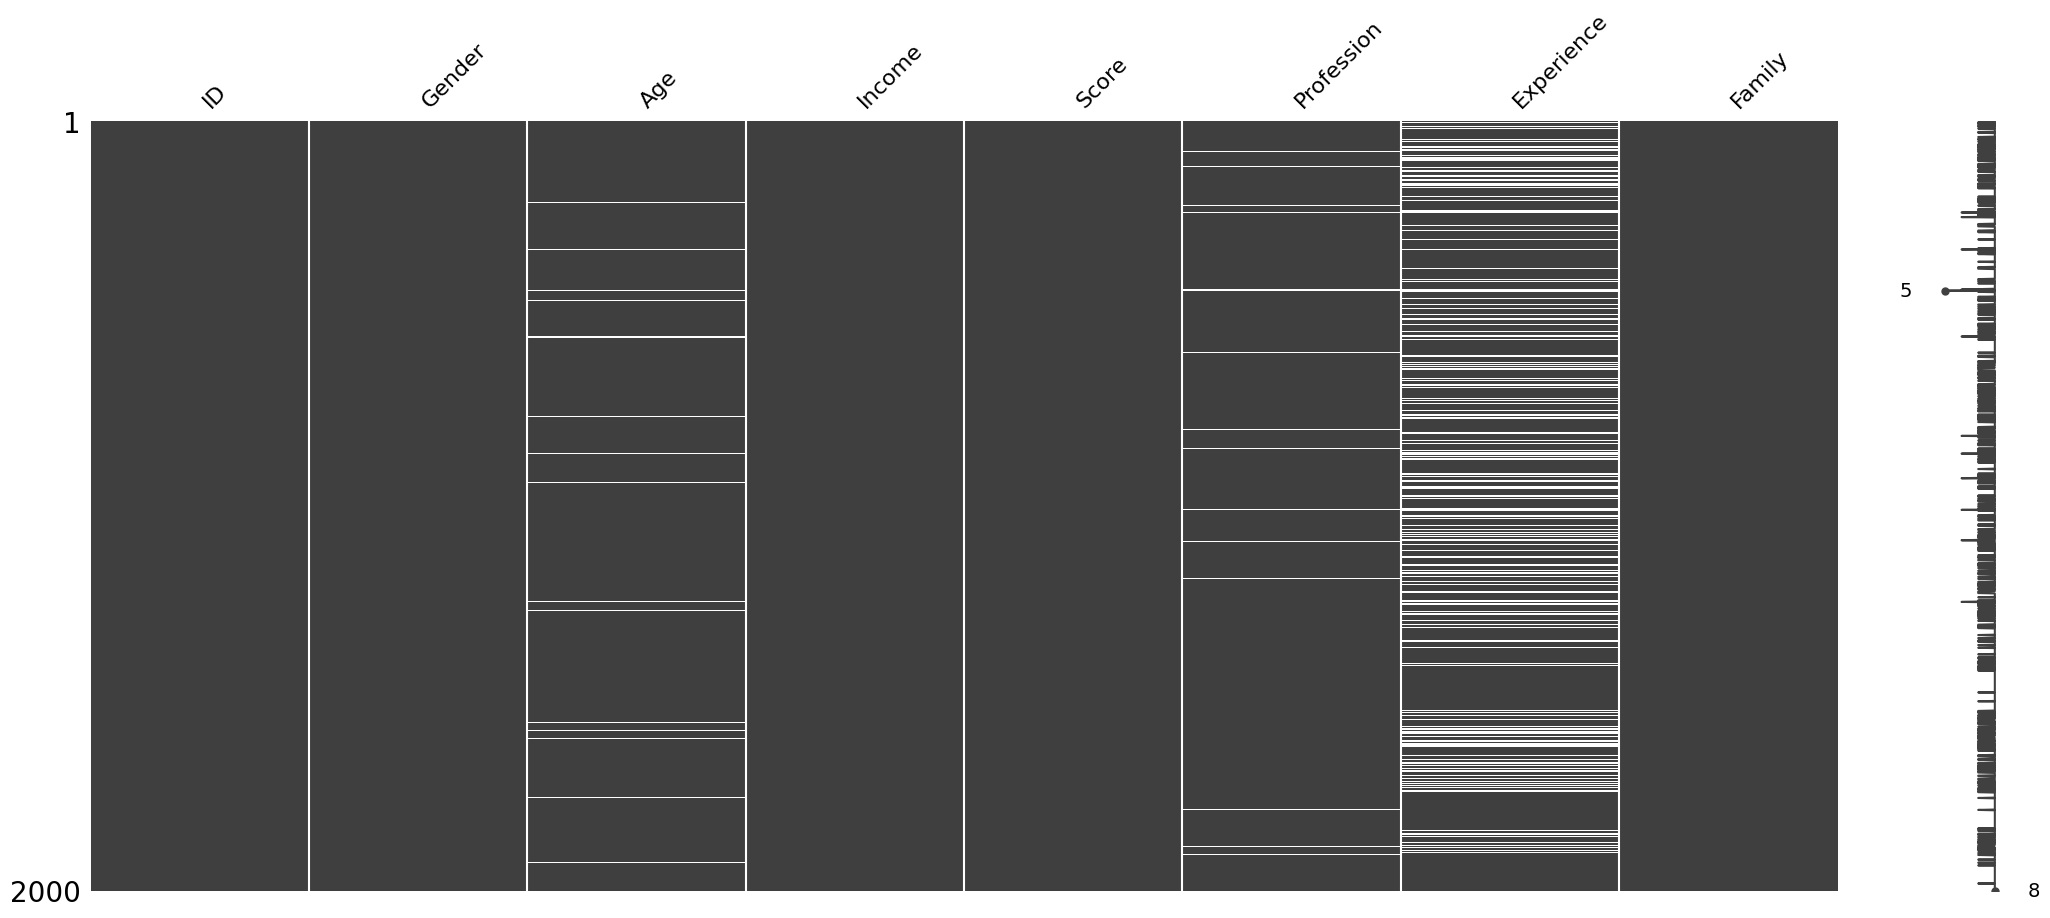

In [89]:
# salvando um NOVO dataset para tratamento de missings

# recuperando os nomes das colunas
col = list(dataset.columns)

# o novo dataset irá conter todas as colunas do dataset original
datasetSemMissings = dataset[col[:]]

# substituindo os zeros por NaN
datasetSemMissings.replace(0, np.nan, inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(datasetSemMissings)

In [90]:
# verificando novamente nulls no dataset
datasetSemMissings.isnull().sum()

ID              0
Gender          0
Age            24
Income          2
Score           2
Profession     35
Experience    431
Family          0
dtype: int64

Vamos substituir os valores faltantes por 0 em 'Income', pois pode haver clientes que não possuem renda. Já nas colunas 'Age', 'Experience' e 'Score', vamos incluir a mediana da coluna nos valores faltantes.

<Axes: >

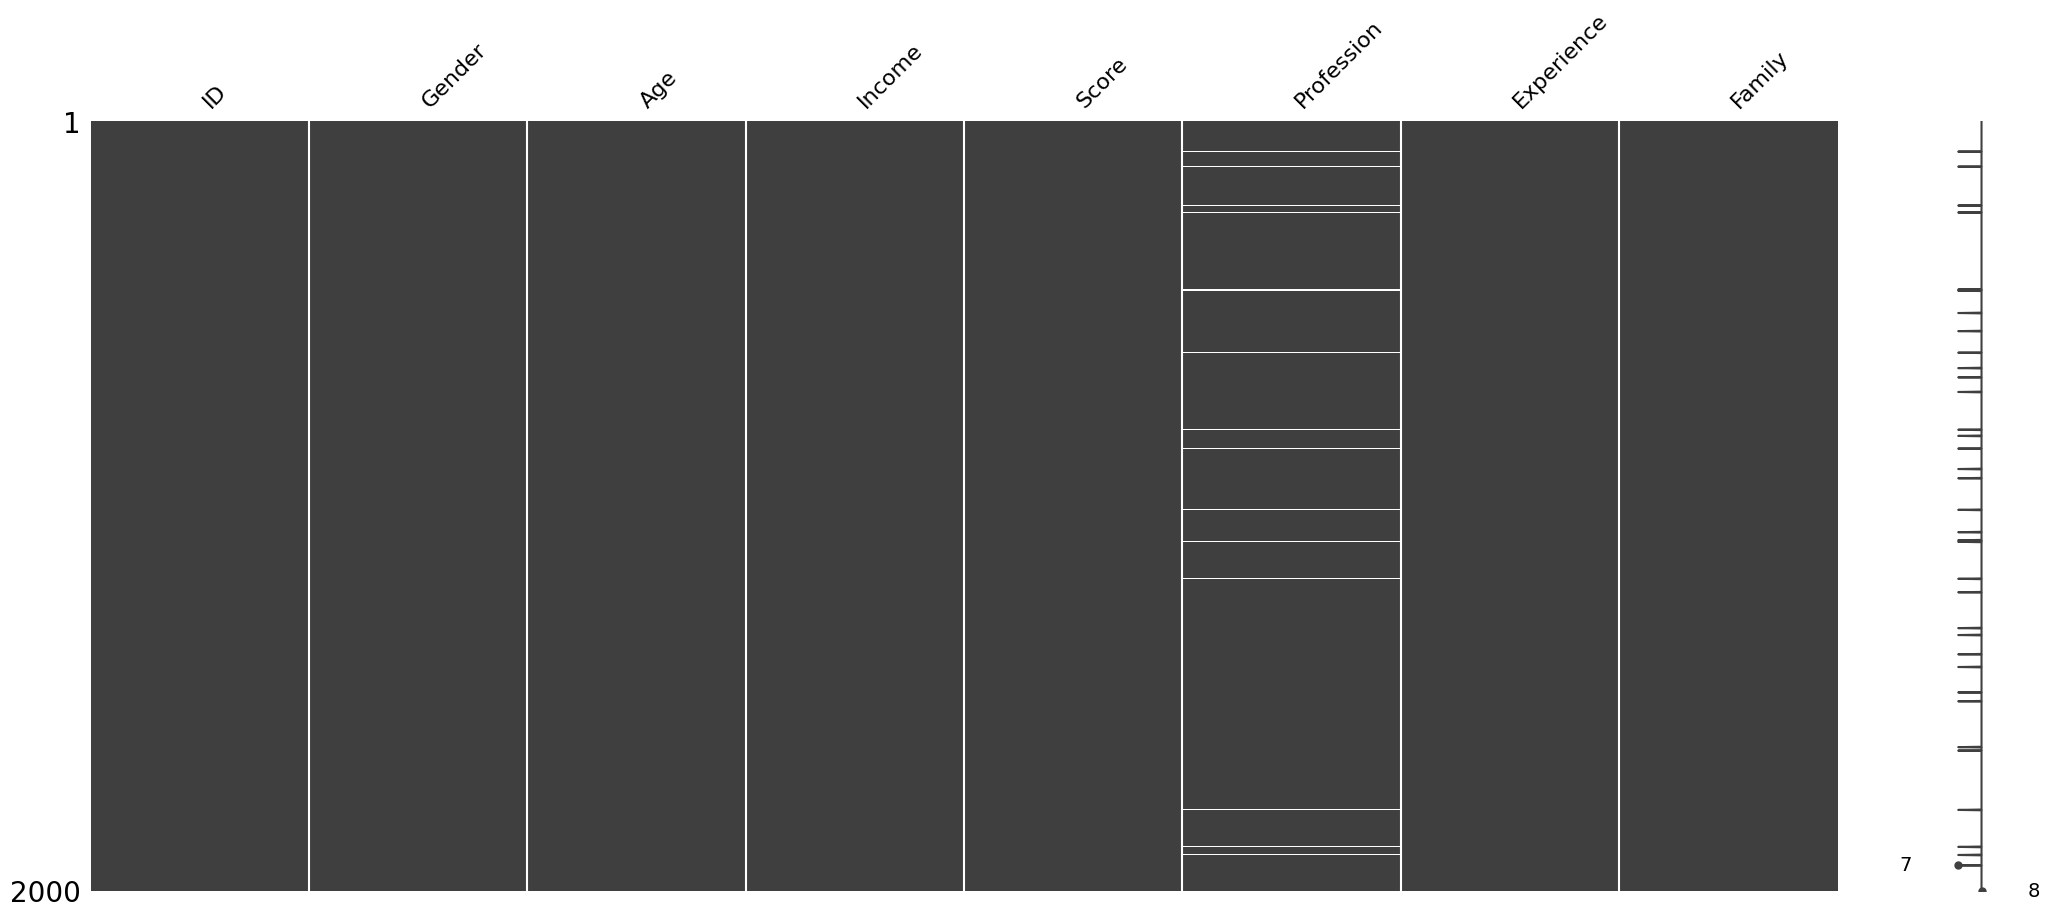

In [91]:
# substituindo os NaN de 'Income' por 0 - voltando aos valores originais desta coluna
datasetSemMissings['Income'].fillna(0, inplace=True)

# substituindo os NaN de 'Age', 'Experience' e 'Score' pela mediana da coluna
datasetSemMissings['Age'].fillna(datasetSemMissings['Age'].median(), inplace=True)
datasetSemMissings['Score'].fillna(datasetSemMissings['Score'].median(), inplace=True)
datasetSemMissings['Experience'].fillna(datasetSemMissings['Experience'].median(), inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(datasetSemMissings)


Como na coluna 'Profession' ainda há missings, vamos excluir as linhas que possuem algum valor faltante nessa coluna.

<Axes: >

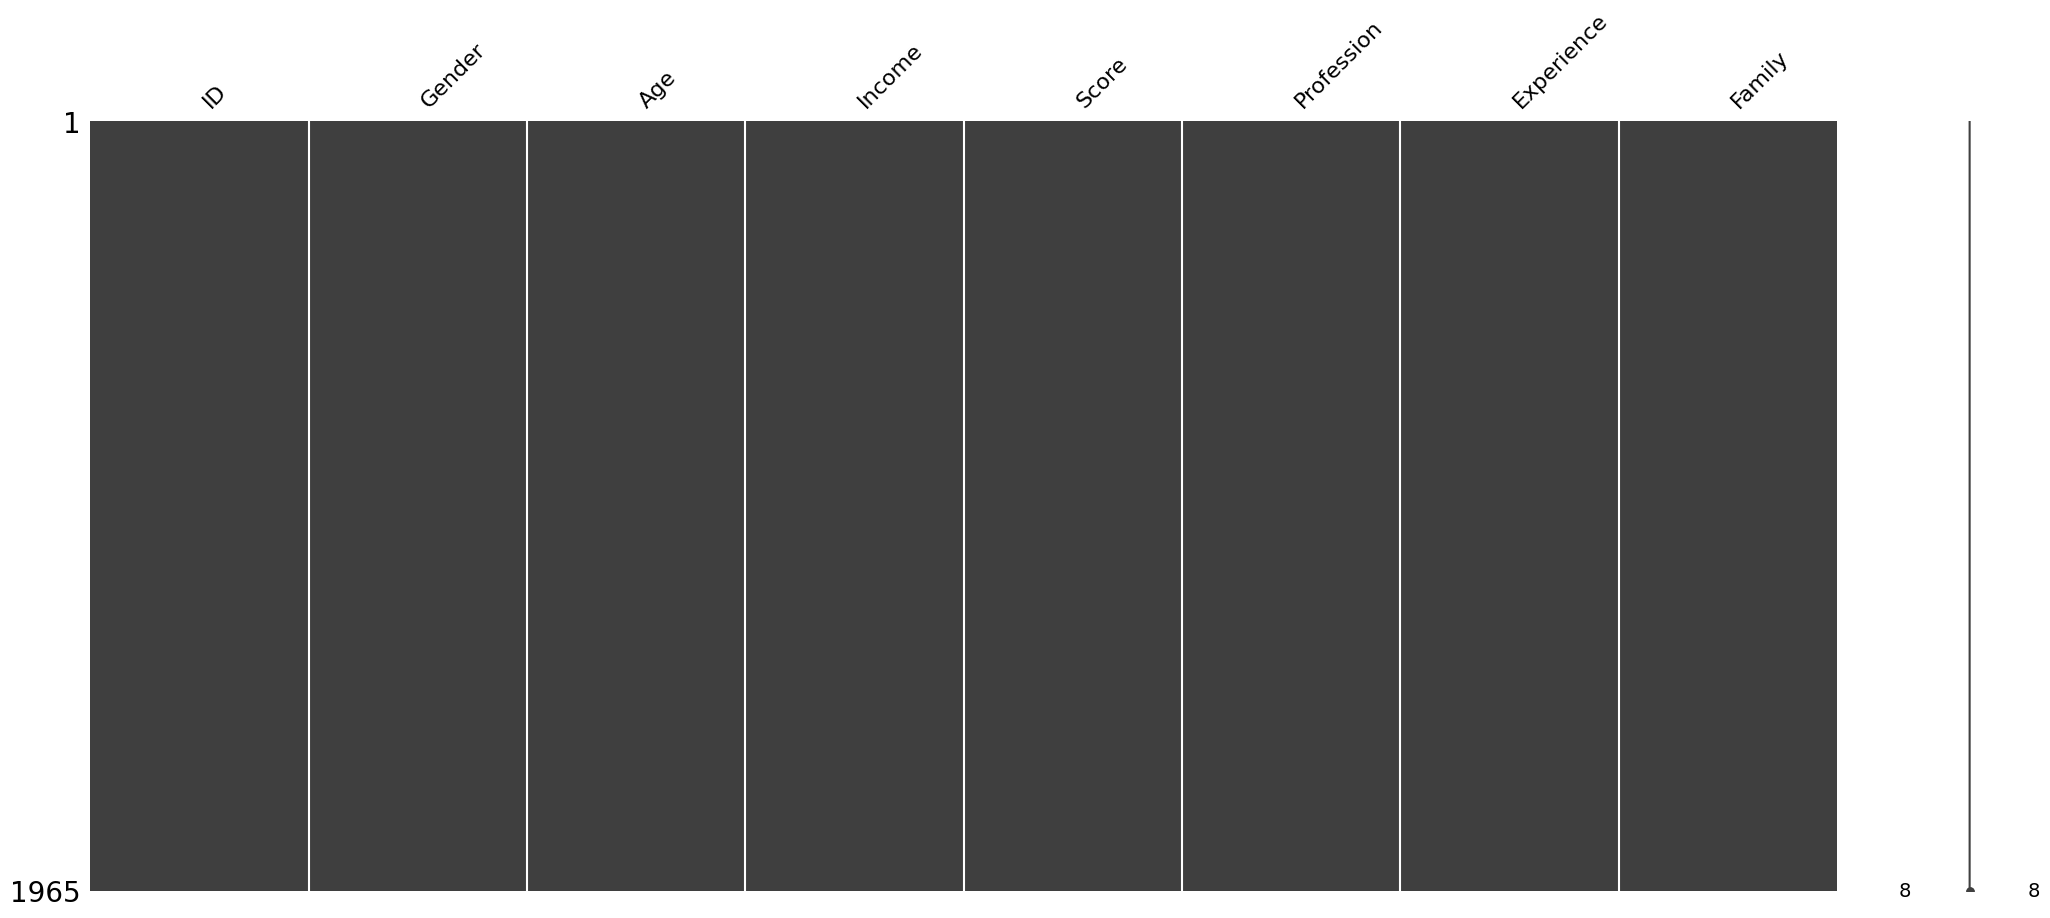

In [92]:
# eliminando linhas que tenham algum valor missing da coluna 'Profession'
datasetSemMissings.dropna(how='any', inplace=True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(datasetSemMissings)

In [93]:
# Retirando variáveis com alta cardinalidade ou variáveis de contagem
datasetSemMissings.drop(columns=['ID'],inplace=True)
datasetSemMissings.head()

,Gender,Age,Income,Score,Profession,Experience,Family
0,Male,19.0,15000.0,39.0,Healthcare,1.0,4
1,Male,21.0,35000.0,81.0,Engineer,3.0,3
2,Female,20.0,86000.0,6.0,Engineer,1.0,1
3,Female,23.0,59000.0,77.0,Lawyer,5.0,2
4,Female,31.0,38000.0,40.0,Entertainment,2.0,6


In [94]:
# Mostra as informações do dataset tratado
datasetSemMissings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      1965 non-null   object 
 1   Age         1965 non-null   float64
 2   Income      1965 non-null   float64
 3   Score       1965 non-null   float64
 4   Profession  1965 non-null   object 
 5   Experience  1965 non-null   float64
 6   Family      1965 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 122.8+ KB


In [95]:
# verificando nulls no dataset tratado
datasetSemMissings.isnull().sum()

Gender        0
Age           0
Income        0
Score         0
Profession    0
Experience    0
Family        0
dtype: int64

###3.2 Tratamento de variáveis categóricas

Nessa etapa, trataremos das variáveis categóricas, referente a dimensionalidade.

Preparando um novo dataset "dataset_model" para ser utilizado no modelo

In [96]:
dataset_model=datasetSemMissings[:]

In [97]:
dataset_model['Profession'].value_counts()

Artist           612
Healthcare       339
Entertainment    234
Engineer         179
Doctor           161
Executive        153
Lawyer           142
Marketing         85
Homemaker         60
Name: Profession, dtype: int64

Do resultado, podemos observar que a maioria das profissões é Artist, Healthcare e Entertainment. Assim vamos substituir os outros por uma categoria chamada 'other'.

In [98]:
# substituindo valores (exceto Artist, Healthcare, Entertainment) por 'other'
prof = ['Artist','Healthcare', 'Entertainment']
dataset_model['Profession'] = dataset_model['Profession'].where(dataset_model['Profession'].isin(prof), 'other')
dataset_model['Profession'].value_counts()

other            780
Artist           612
Healthcare       339
Entertainment    234
Name: Profession, dtype: int64

###3.3 Transformação das variáveis categóricas - One Hot Encoding

Vamos tranformar as variáveis categóricas não ordinais "Gender" e "Profession" em variáveis numéricas, utilizando codificação One-Hot Encoding. Começando pela separação das variáveis preditoras.

In [99]:
# separando as colunas preditoras e target
col_y = ['Score']

# separando atributos preditores e alvo
X = dataset_model[:].drop(col_y, axis = 1)  # variaveis preditoras
y = dataset_model[col_y[:]] # variavel alvo

Em seguida, serão listadas as variáveis preditoras categóricas que serão codificadas.

In [100]:
# listando os atributos categóricos que serão codificadas com one-hot encoded
object_cols = [col for col in X.columns if X[col].dtype == "object"]

# Novo nome das colunas codificadas
cat_cols = object_cols
cat_cols_encoded = []
for col in cat_cols:
  cat_cols_encoded += [f"{col[0]}_{cat}" for cat in list(X[col].unique())]

print('Colunas categóricas que serão codificadas via one-hot encoding:', object_cols)
print(f'Novos nomes de colunas categóricas:{cat_cols_encoded}')

Colunas categóricas que serão codificadas via one-hot encoding: ['Gender', 'Profession']
Novos nomes de colunas categóricas:['G_Male', 'G_Female', 'P_Healthcare', 'P_other', 'P_Entertainment', 'P_Artist']


Agora, aplicamos a transformação ONE HOT ENCODING.

In [101]:
# aplica codificador one-hot a cada coluna com dados categóricos
OH_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

OH_cols_X = pd.DataFrame(OH_encoder.fit_transform(X[object_cols]), columns=cat_cols_encoded)

# índice removido de codificação one-hot; insere de volta
OH_cols_X.index = X.index

# remove colunas categóricas (substituirá por codificação one-hot)
X.drop(object_cols, axis=1, inplace=True)

# adiciona colunas codificadas one-hot a recursos numéricos
X = X.join(OH_cols_X)

#checando o tamanho
print(f'X: {X.shape}')

X: (1965, 10)


In [102]:
X.head()

,Age,Income,Experience,Family,G_Male,G_Female,P_Healthcare,P_other,P_Entertainment,P_Artist
0,19.0,15000.0,1.0,4,0.0,1.0,0.0,0.0,1.0,0.0
1,21.0,35000.0,3.0,3,0.0,1.0,0.0,0.0,0.0,1.0
2,20.0,86000.0,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0
3,23.0,59000.0,5.0,2,1.0,0.0,0.0,0.0,0.0,1.0
4,31.0,38000.0,2.0,6,1.0,0.0,0.0,1.0,0.0,0.0


###3.4 Separação em conjunto de treino e conjunto de teste

Agora, vamos dividir o dataset em dois componentes de base de treino e teste, apresentando as entradas X e a saída Y.

In [103]:
# definindo parametros de teste/treino
test_size = 0.20 # tamanho do conjunto de testes.
seed = 7 # semente geradora dos numeros aleatórios

# definindo dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
     test_size=test_size, shuffle=True, random_state=seed) # sem estratificação

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}\nX_test: {X_test.shape}, y_test: {y_test.shape}')

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

X_train: (1572, 10), y_train: (1572, 1)
X_test: (393, 10), y_test: (393, 1)


###3.5 Seleção de Atributos

Agora, vamos executar o método de seleção univariada, para selecionar os 4 atributos mais relevantes, que podem ser utilizados como variáveis preditoras, utilizando a classe SelectKBest.

In [104]:
# Seleção de atributos com SelectKBest
best_var = SelectKBest(score_func=f_regression, k=4)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = best_var.fit(X_train, y_train)

# Reduz X para os atributos selecionados
features = fit.transform(X_train)

# Resultados
print('\nNúmero original de atributos:', X_train.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])

# Exibe os atributos orginais
print('\nAtributos Originais:', X_train.columns)

# Exibe as pontuações de cada atributos e os escolhidos (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
ncol_X = best_var.get_feature_names_out(input_features=X_train.columns)
print('\nScores dos Atributos Originais:', fit.scores_)
print('\nAtributos Selecionados:', ncol_X)


Número original de atributos: 10

Número reduzido de atributos: 4

Atributos Originais: Index(['Age', 'Income', 'Experience', 'Family', 'G_Male', 'G_Female',
       'P_Healthcare', 'P_other', 'P_Entertainment', 'P_Artist'],
      dtype='object')

Scores dos Atributos Originais: [0.395 2.679 1.896 0.411 0.068 0.068 2.413 0.982 0.274 2.943]

Atributos Selecionados: ['Income' 'Experience' 'P_Healthcare' 'P_Artist']


## 4. Modelagem e Inferência

Iniciaremos agora a etapa de modelagem e inferência, mas não sabemos de antemão quais algoritmos performarão bem nesse conjunto de dados. Usaremos a validação cruzada para treinar e avaliar os modelos usando a métrica acurácia.

###4.1 Criação e avaliação de modelos: linha de base

Primeiramente, iremos avaliar os algoritmos com a configuração padrão de hiperparâmetros da scikit-Learn. Criaremos os modelos com os algoritmos de regressão abaixo adicionando-os em uma lista, para avaliar o MSR e o RMSE dos modelos treinados:

- Regressão linear;

- Regressão linear com regularização Ridge;

- Regressão linear com regularização Lasso;

- KNN;

- Árvore de regressão (CART);

- SVM

LR: MSE 775.60 (46.34) - RMSE 27.85
Ridge: MSE 775.59 (46.33) - RMSE 27.85
Lasso: MSE 772.38 (42.47) - RMSE 27.79
KNN: MSE 908.84 (52.91) - RMSE 30.15
CART: MSE 1579.57 (166.91) - RMSE 39.74
SVM: MSE 772.57 (41.89) - RMSE 27.80
Bagging: MSE 843.92 (59.70) - RMSE 29.05
RF: MSE 836.06 (47.40) - RMSE 28.91
ET: MSE 895.97 (40.64) - RMSE 29.93
Ada: MSE 773.39 (42.48) - RMSE 27.81
GB: MSE 801.61 (46.78) - RMSE 28.31
Voting: MSE 838.30 (56.67) - RMSE 28.95


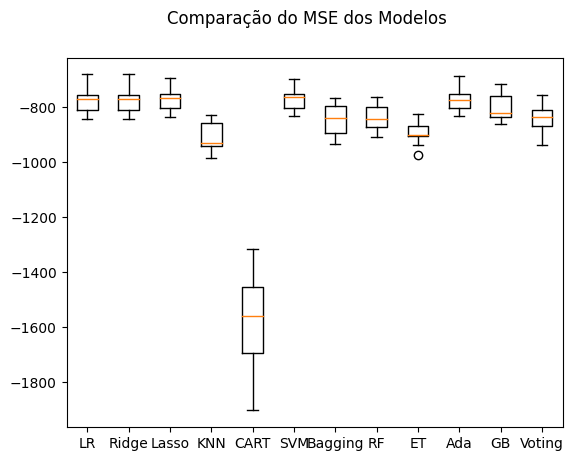

In [105]:
# definindo uma seed global para esta célula de código
np.random.seed(7)

# Lista que armazenará os modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Definindo os parâmetros para o BaggingRegressor
base = DecisionTreeRegressor()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingRegressor
bases = []
model1 = LinearRegression()
bases.append(('LR', model1))
model2 = DecisionTreeRegressor()
bases.append(('CART', model2))
model3 = SVR()
bases.append(('SVM', model3))
model4 = KNeighborsRegressor()
bases.append(('KNN', model4))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingRegressor(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostRegressor(n_estimators=num_trees)))
models.append(('GB', GradientBoostingRegressor(n_estimators=num_trees)))
models.append(('Voting', VotingRegressor(bases)))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

O modelo Regressão Linear com Regularização Lasso apresentou a melhor performance nesta avaliação inicial.
Analisando os resultados, verificamos que, considerando o MSE (e, consequentemente, o RMSE), o modelo treinado com o Regressão Linear com Regularização Lasso apresentou os melhores resultados, indicando que, possivelmente, seguiríamos com ela como escolha de algoritmo. Nesse caso, construiremos um novo modelo, treinado com toda a base de treino.

Preparando o dataframe com as colunas selecionadas

In [106]:
# novo conjunto de atributos selecionados
X_train = X_train[ncol_X[:]]# variaveis preditoras
X_test = X_test[ncol_X[:]]# variaveis preditoras

Construindo um novo modelo baseado em regressão Linear com regularização Lasso com todo conjunto de treino, para então ser avaliado utilizando a base de teste.

In [107]:
# Criando o modelo lasso com todo o conjunto de treino
model = Lasso()
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictions)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 816.27
RMSE 28.57


In [108]:
X_train.shape

(1572, 4)

### 4.2 Criação e avaliação de modelos: dados padronizados e normalizados

Em seguida, vamos repetir esse processo, utilizando a biblioteca Pipeline para criar e avaliar os modelos através da validação cruzada com os dados padronizados e normalizados (evitando o data leakage) e comparar o seu resultado com os modelos treinados com o dataset original:

LR-orig: -772.527 (45.520)
Ridge-orig: -772.515 (45.517)
Lasso-orig: -771.185 (42.937)
KNN-orig: -913.411 (52.284)
CART-orig: -1557.322 (155.462)
SVM-orig: -772.553 (41.900)
Bag-orig: -950.223 (66.557)
RF-orig: -974.922 (74.669)
ET-orig: -1218.389 (94.331)
Ada-orig: -772.026 (43.407)
GB-orig: -796.122 (42.208)
Vot-orig: -838.340 (68.318)
LR-padr: -772.527 (45.520)
Ridge-padr: -772.523 (45.518)
Lasso-padr: -773.502 (42.927)
KNN-padr: -925.192 (60.094)
CART-padr: -1573.021 (171.491)
SVM-padr: -775.109 (48.170)
Bag-padr: -947.094 (65.198)
RF-padr: -977.317 (71.684)
ET-padr: -1211.384 (86.738)
Ada-padr: -774.789 (37.952)
GB-padr: -796.126 (44.738)
Vot-padr: -840.321 (73.509)
LR-norm: -772.527 (45.520)
Ridge-norm: -772.495 (45.496)
Lasso-norm: -772.129 (42.196)
KNN-norm: -923.313 (59.255)
CART-norm: -1575.984 (169.877)
SVM-norm: -773.599 (47.427)
Bag-norm: -954.600 (70.302)
RF-norm: -980.698 (74.232)
ET-norm: -1219.620 (93.012)
Ada-norm: -772.598 (44.133)
GB-norm: -795.915 (42.317)
Vot-norm

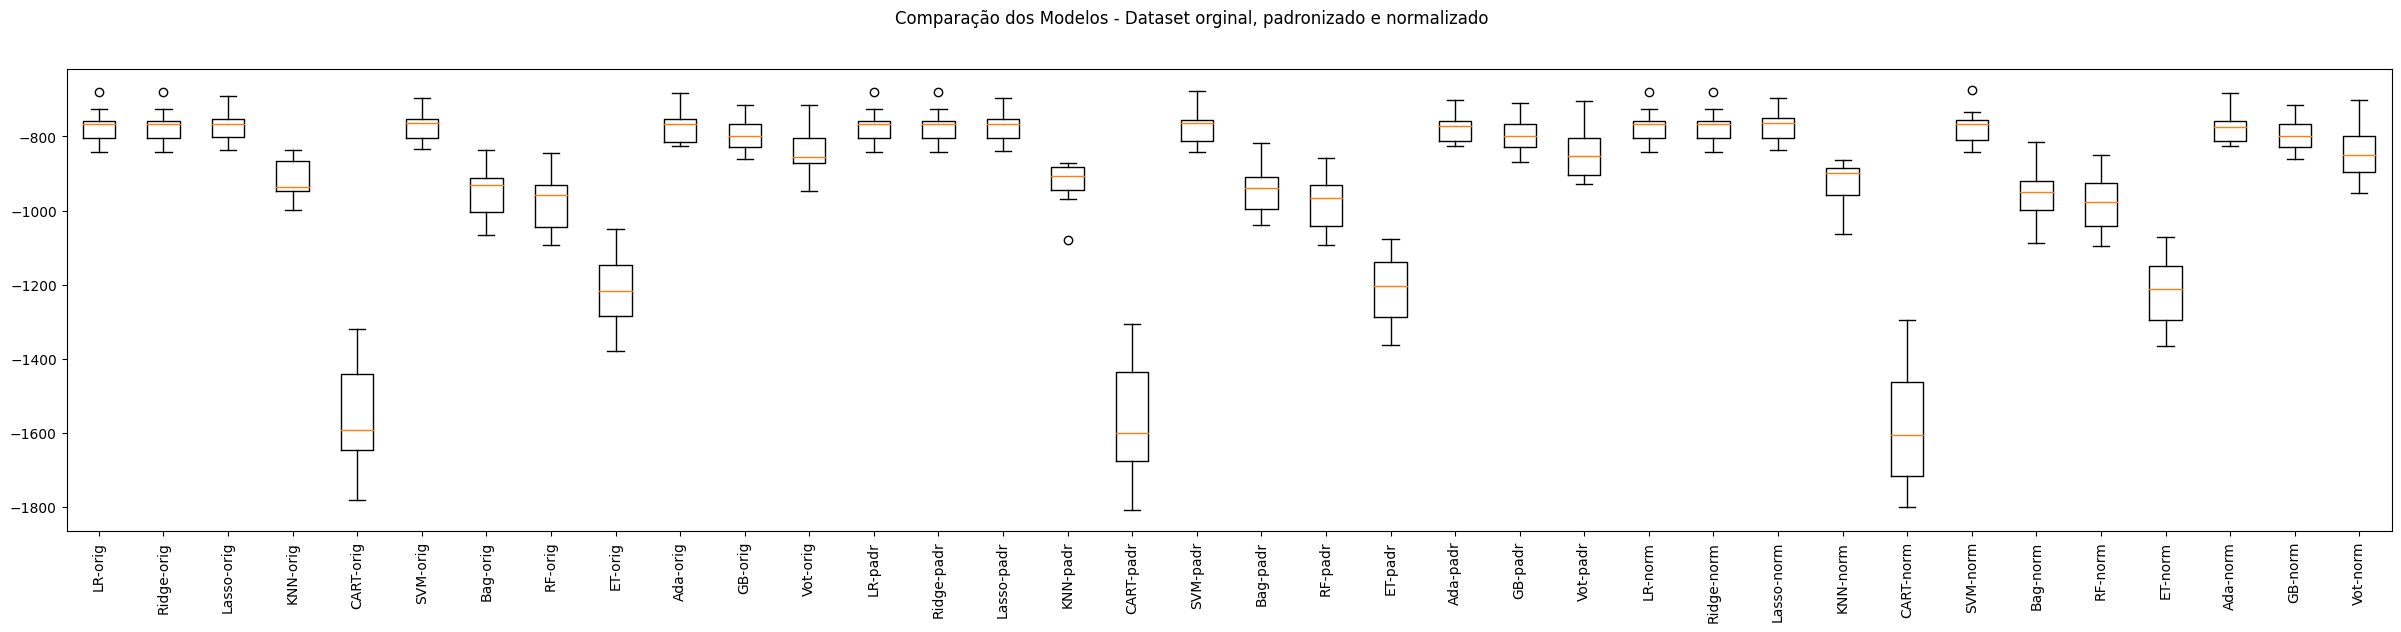

In [109]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_lin = ('LR', LinearRegression())
ridge = ('Ridge', Ridge())
lasso = ('Lasso', Lasso())
knn = ('KNN', KNeighborsRegressor())
cart = ('CART', DecisionTreeRegressor())
svr = ('SVM', SVR())
bagging = ('Bag', BaggingRegressor(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostRegressor(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingRegressor(n_estimators=num_trees))
voting = ('Voting', VotingRegressor(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_lin])))
pipelines.append(('Ridge-orig', Pipeline([ridge])))
pipelines.append(('Lasso-orig', Pipeline([lasso])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVM-orig', Pipeline([svr])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_lin])))
pipelines.append(('Ridge-padr', Pipeline([standard_scaler, ridge])))
pipelines.append(('Lasso-padr', Pipeline([standard_scaler, lasso])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svr])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_lin])))
pipelines.append(('Ridge-norm', Pipeline([min_max_scaler, ridge])))
pipelines.append(('Lasso-norm', Pipeline([min_max_scaler, lasso])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svr])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(30,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

O modelo com ensemble Regressão Linear com regularização Lasso com dados originais apresentou a melhor performance dentre os modelos de regressão avaliados.

### 4.3 Otimização de Hiperparâmetros

Agora iremos utilizar os resultados obtidos nos pipelines de avaliação de modelo, para executar a otimização dos hiperparâmetros.

In [110]:
# Tuning do Lasso

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
lasso = ('Lasso', Lasso())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('Lasso-orig', Pipeline([lasso])))
pipelines.append(('Lasso-padr', Pipeline([lasso])))
pipelines.append(('Lasso-norm', Pipeline([lasso])))

param_grid = {
    'Lasso__max_iter': [0, 1000],
    'Lasso__fit_intercept':[True, False],
    'Lasso__precompute': [True, False],
    'Lasso__positive': [True, False],
    'Lasso__selection': ['cyclic', 'random'],
    'Lasso__warm_start': [True, False],
    'Lasso__tol': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("%s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Lasso-orig - Melhor: -770.487025 usando {'Lasso__fit_intercept': True, 'Lasso__max_iter': 1000, 'Lasso__positive': False, 'Lasso__precompute': False, 'Lasso__selection': 'random', 'Lasso__tol': 10, 'Lasso__warm_start': False}
Lasso-padr - Melhor: -770.237696 usando {'Lasso__fit_intercept': True, 'Lasso__max_iter': 1000, 'Lasso__positive': False, 'Lasso__precompute': True, 'Lasso__selection': 'random', 'Lasso__tol': 10, 'Lasso__warm_start': False}
Lasso-norm - Melhor: -770.432880 usando {'Lasso__fit_intercept': True, 'Lasso__max_iter': 1000, 'Lasso__positive': True, 'Lasso__precompute': True, 'Lasso__selection': 'random', 'Lasso__tol': 1, 'Lasso__warm_start': False}


Com a otimização dos hiperparêmetros, o melhor resultado foi alcançado com os dados padronizados

### 5. Finalização do Modelo

A seguir, finalizaremos o modelo, treinando-o em todo o conjunto de dados de treinamento (sem validação cruzada), e faremos predições para o conjunto de dados de teste que foi separado logo no início da prática, a fim de confirmarmos os resultados.

Como não podemos calcular a acurácia de um modelo de regressão, vamos utilizar o erro quadrático médio (MSE) e a raiz do erro quadrático médio (RMSE) como indicadores de desempenho do modelo

In [111]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = Lasso()
model.fit(rescaledX, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# Estimando o MSE e o RMSE no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
mse = mean_squared_error(y_test, predictions)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 811.82
RMSE 28.49


###6. Conclusão

Por meio do conjunto de teste, verificamos que alcançamos um MSE de 811.82 em dados não vistos. Esse resultado foi ainda melhor do que a nossa avaliação anterior, que alcançou o valor do MSE de 816.27.